In [27]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pylab as plt
import pandas as pd
import h5py
from scipy.stats import wasserstein_distance as w_d

plt.rcParams['font.size'] = 14


In [28]:
file_path = '/global/cfs/cdirs/m4236/cosmosweb/catalogs/hsc_jwst_matched_with_images_high_snr'
f = h5py.File(file_path, 'r')

list(f.keys())


['Confidence_level',
 'bulge_radius',
 'dec',
 'dec_specz',
 'disk_radius',
 'flux_err-cal_model_cfht-u',
 'flux_err-cal_model_f115w',
 'flux_err-cal_model_f150w',
 'flux_err-cal_model_f277w',
 'flux_err-cal_model_f444w',
 'flux_err-cal_model_hsc-g',
 'flux_err-cal_model_hsc-i',
 'flux_err-cal_model_hsc-r',
 'flux_err-cal_model_hsc-y',
 'flux_err-cal_model_hsc-z',
 'flux_model_cfht-u',
 'flux_model_f115w',
 'flux_model_f150w',
 'flux_model_f277w',
 'flux_model_f444w',
 'flux_model_hsc-g',
 'flux_model_hsc-i',
 'flux_model_hsc-r',
 'flux_model_hsc-y',
 'flux_model_hsc-z',
 'hsc_images',
 'id_specz_khostovan25',
 'jwst_images',
 'lephare_photozs',
 'lp_age',
 'lp_mass',
 'lp_sfr',
 'lp_ssfr',
 'lp_type',
 'lp_zpdf_l68',
 'lp_zpdf_u68',
 'mag_model_cfht-u',
 'mag_model_f115w',
 'mag_model_f150w',
 'mag_model_f277w',
 'mag_model_f444w',
 'mag_model_hsc-g',
 'mag_model_hsc-i',
 'mag_model_hsc-r',
 'mag_model_hsc-y',
 'mag_model_hsc-z',
 'photoz',
 'ra',
 'ra_specz',
 'specz']

In [29]:
model_sizes = ['tiny', 'small', 'base', 'large']
n = 5000
telescope = 'jwst'
upsampled = True

dir_out = '/pscratch/sd/a/ashodkh/platonic_universe/embeddings/'

embeddings = {}

for model_size in model_sizes:
    if upsampled:
        embeddings[model_size] = np.load(dir_out + f'embeddings_{telescope}_{n}_convnext{model_size}_upsampled_images.npy')
    else:
        embeddings[model_size] = np.load(dir_out + f'embeddings_{telescope}_{n}_convnext{model_size}.npy')

    

In [30]:
nns = {}
k = 10
for model_size in model_sizes:
    nns[model_size] = NearestNeighbors(n_neighbors=k, metric="minkowski").fit(embeddings[model_size]).kneighbors(return_distance=False)
    

In [31]:
#params = ['mag_model_hsc-g', 'lp_mass', 'lp_ssfr', 'lephare_photozs']
params = ['mag_model_f150w', 'lp_mass', 'lp_ssfr', 'lephare_photozs']

w_d_mean = {}

for j, param in enumerate(params):
    print(param)
    w_d_mean[param] = {}
    param_arr = f[param][:n]
    for m, model_size in enumerate(model_sizes[:-1]):
        w_ds = [w_d(param_arr[nns[model_size][ind]], param_arr[nns[model_sizes[m+1]][ind]]) for ind in range(n)]
        w_d_mean[param][model_size + ' vs. ' + model_sizes[m+1]] = np.mean(w_ds)
        print(model_size + ' vs. ' + model_sizes[m+1] + f' w_d={np.mean(w_ds)}')
        

mag_model_f150w
tiny vs. small w_d=0.3456859358215332
small vs. base w_d=0.33228545654296876
base vs. large w_d=0.30321616397857665
lp_mass
tiny vs. small w_d=0.2704161599063874
small vs. base w_d=0.2548029279613495
base vs. large w_d=0.25052181887626646
lp_ssfr
tiny vs. small w_d=0.6205776053237915
small vs. base w_d=0.5960966749286652
base vs. large w_d=0.562983123960495
lephare_photozs
tiny vs. small w_d=0.3011812823675014
small vs. base w_d=0.28833436477827834
base vs. large w_d=0.2768022387195658


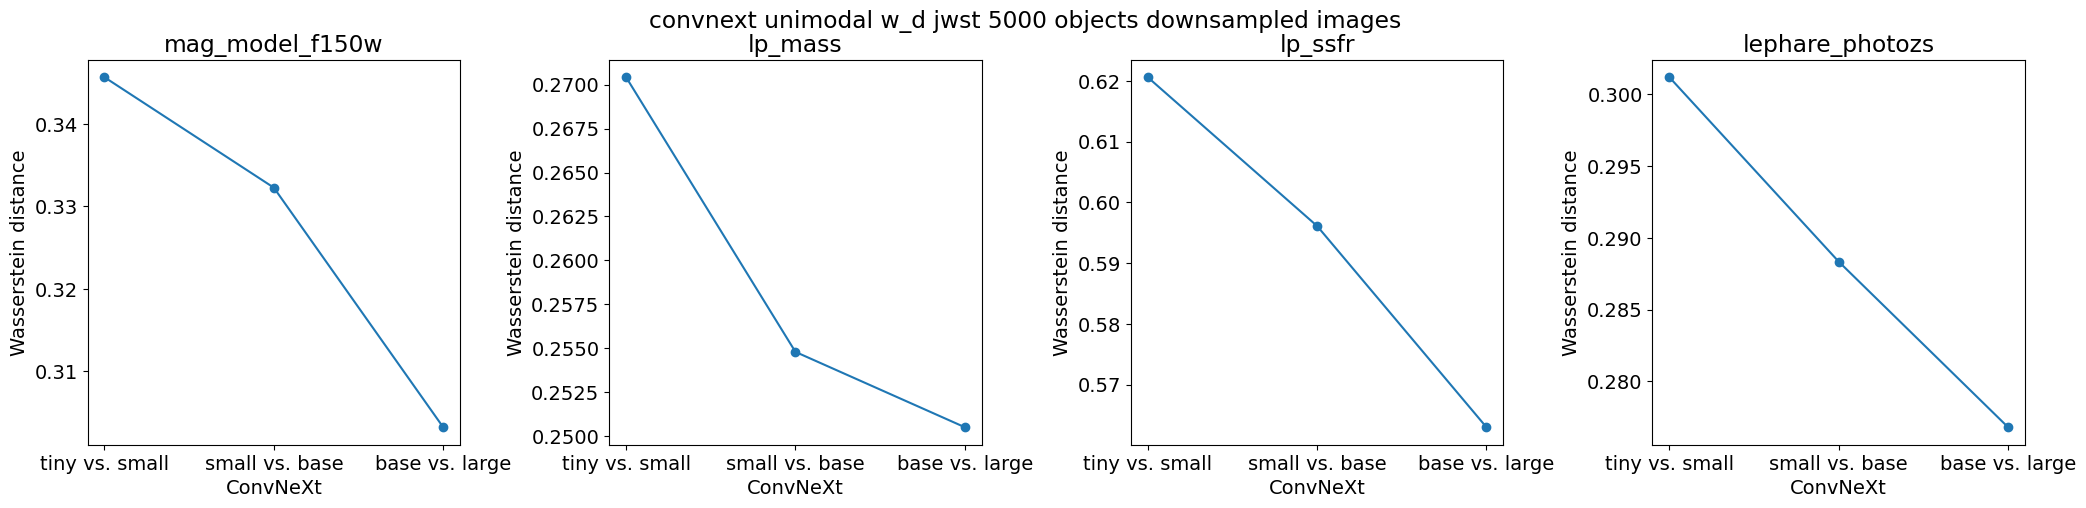

In [33]:
fig, ax = plt.subplots(ncols=len(params), figsize=(25,5))
fig.subplots_adjust(wspace=0.4)

for j, param in enumerate(params):
    ax[j].plot([1,2,3], [w_d_mean[param]['tiny vs. small'],w_d_mean[param]['small vs. base'],w_d_mean[param]['base vs. large']], 'o-', label='wasserstein distance mean')
    ax[j].set_title(param)
    ax[j].set_xlabel('ConvNeXt')
    ax[j].set_ylabel('Wasserstein distance')
    ax[j].set_xticks([1,2,3])
    ax[j].set_xticklabels(list(w_d_mean[param].keys()))

if upsampled:
    fig.suptitle(f'convnext unimodal w_d {telescope} {n} objects upsampled images')
    plt.savefig(f'convnext_unimodal_w_d_{telescope}_{n}_upsampled_images.png', bbox_inches='tight')
else:
    fig.suptitle(f'convnext unimodal w_d {telescope} {n} objects')
    plt.savefig(f'convnext_unimodal_w_d_{telescope}_{n}.png', bbox_inches='tight')
